In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Plant_Classification.zip to Plant_Classification.zip


In [ ]:
!unzip -uq "/content/Plant_Classification.zip" -d "/content"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [ ]:
train_dir='/content/Plant_Classification'


In [ ]:
GATEGORIES = ['Araowla', 'Chinese carnation', 'Colencha', 'Gauva', 'Geranium', 'Jamun', 'Ocimum',
              'Ocimum basilicum', 'Petunia', 'Pomegranate', 'Pongamia Pinnata', 'Tagetes', 'Verbina', 'winka']

In [ ]:
print ("class : ") 
for i in range(len(GATEGORIES)): 
    print (i, end = " ") 
    print (GATEGORIES[i]) 

class : 
0 Araowla
1 Chinese carnation
2 Colencha
3 Gauva
4 Geranium
5 Jamun
6 Ocimum
7 Ocimum basilicum
8 Petunia
9 Pomegranate
10 Pongamia Pinnata
11 Tagetes
12 Verbina
13 winka


In [ ]:
print('Number of classes:',len(GATEGORIES))

Number of classes: 14


In [ ]:
module_selection = ("mobilenet_v2", 224, 1280) 
handle_base, pixels, FV_SIZE = module_selection
MODULE_HANDLE ="https://tfhub.dev/google/tf2-preview/{}/feature_vector/2".format(handle_base)
IMAGE_SIZE = (pixels, pixels)
BATCH_SIZE = 16 

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest',
      validation_split=0.2 )
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)


validation_generator = train_datagen.flow_from_directory(
    train_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    subset="validation",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE)

Found 3080 images belonging to 14 classes.
Found 770 images belonging to 14 classes.


In [ ]:
feature_extractor = hub.KerasLayer(MODULE_HANDLE,input_shape=IMAGE_SIZE+(3,), output_shape=[FV_SIZE]  )


In [ ]:
do_fine_tuning = False 
if do_fine_tuning:
  feature_extractor.trainable = True
  for layer in base_model.layers[-30:]:
    layer.trainable =True
  
else:
  feature_extractor.trainable = False

In [ ]:
print("Building model with", MODULE_HANDLE)
model = Sequential()
model.add(feature_extractor)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(train_generator.num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0001)))



model.summary()

Building model with https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               655872    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 14)                7182      
Total params: 2,921,038
Trainable params: 663,054
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss='categorical_crossentropy',metrics=['accuracy'])


In [ ]:
#filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

In [ ]:
EPOCHS=15
history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)




Epoch 1/15
192/192 [==============================] - 157s 820ms/step - loss: 0.0438 - accuracy: 0.9879 - val_loss: 0.0358 - val_accuracy: 0.9909
Epoch 2/15
192/192 [==============================] - 158s 822ms/step - loss: 0.0497 - accuracy: 0.9886 - val_loss: 0.0163 - val_accuracy: 0.9948
Epoch 3/15
192/192 [==============================] - 157s 820ms/step - loss: 0.0222 - accuracy: 0.9951 - val_loss: 0.0266 - val_accuracy: 0.9948
Epoch 4/15
192/192 [==============================] - 157s 818ms/step - loss: 0.0218 - accuracy: 0.9931 - val_loss: 0.0231 - val_accuracy: 0.9935
Epoch 5/15
192/192 [==============================] - 158s 824ms/step - loss: 0.0340 - accuracy: 0.9896 - val_loss: 0.0451 - val_accuracy: 0.9896
Epoch 6/15
192/192 [==============================] - 159s 829ms/step - loss: 0.0199 - accuracy: 0.9935 - val_loss: 0.0200 - val_accuracy: 0.9935
Epoch 7/15
192/192 [==============================] - 160s 834ms/step - loss: 0.0365 - accuracy: 0.9918 - val_loss: 0.0204 -

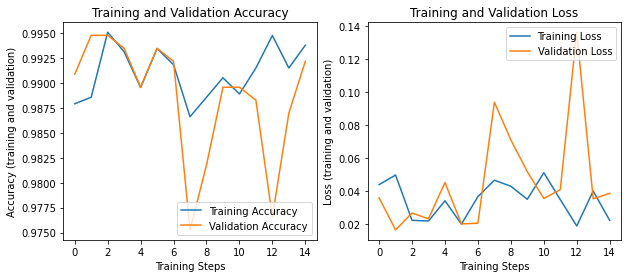

In [ ]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

Source: class: Chinese carnation, file: Chinese carnation/Chinese carnation_103.JPEG
class: Petunia, confidence: 0.967140


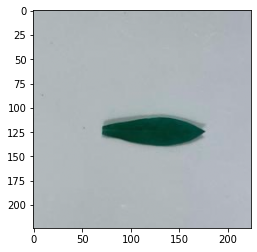

<Figure size 432x288 with 0 Axes>

Source: class: Pomegranate, file: Pomegranate/Pomegranate_118.JPG
class: Pomegranate, confidence: 0.996701


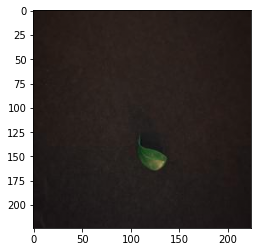

Source: class: Jamun, file: Jamun/Jamun_116.JPG
class: Jamun, confidence: 0.999999


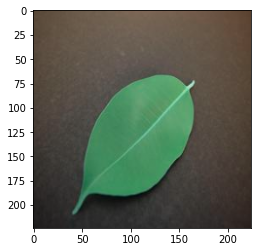

<Figure size 432x288 with 0 Axes>

Source: class: Tagetes, file: Tagetes/Tagetes_119.JPEG
class: Tagetes, confidence: 1.000000


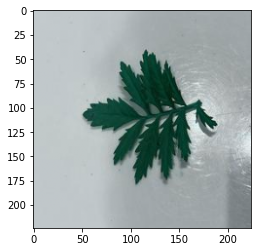

<Figure size 432x288 with 0 Axes>

Source: class: Gauva, file: Gauva/Gauva_139.JPG
class: Gauva, confidence: 0.998442


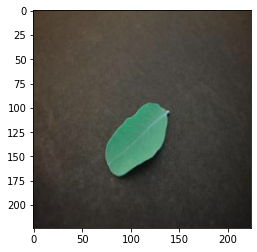

<Figure size 432x288 with 0 Axes>

Source: class: winka, file: winka/winka_136.jpeg
class: winka, confidence: 1.000000


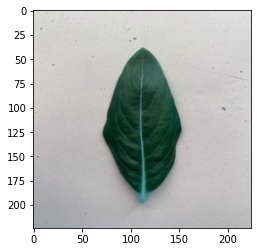

<Figure size 432x288 with 0 Axes>

Source: class: Geranium, file: Geranium/Geranium_109.jpeg
class: Geranium, confidence: 0.999468


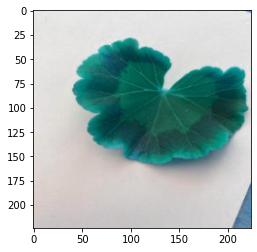

<Figure size 432x288 with 0 Axes>

Source: class: Araowla, file: Araowla/Araowla_141.JPEG
class: Araowla, confidence: 1.000000


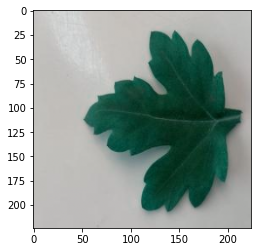

<Figure size 432x288 with 0 Axes>

Source: class: Jamun, file: Jamun/Jamun_125.JPG
class: Jamun, confidence: 0.999652


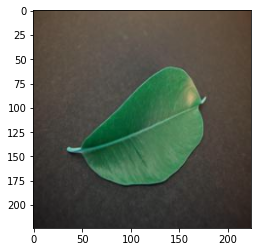

<Figure size 432x288 with 0 Axes>

Source: class: Ocimum basilicum, file: Ocimum basilicum/Ocimum basilicum_11.JPG
class: Ocimum basilicum, confidence: 0.999999


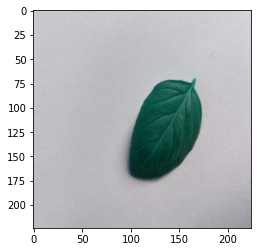

<Figure size 432x288 with 0 Axes>

Source: class: Verbina, file: Verbina/Verbina_115.JPEG
class: Verbina, confidence: 1.000000


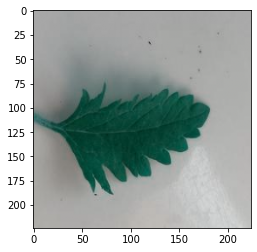

<Figure size 432x288 with 0 Axes>

Source: class: Gauva, file: Gauva/Gauva_103.JPG
class: Gauva, confidence: 0.999931


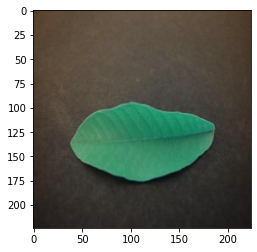

<Figure size 432x288 with 0 Axes>

Source: class: Geranium, file: Geranium/Geranium_118.jpeg
class: Geranium, confidence: 1.000000


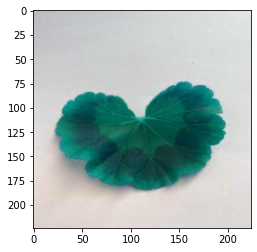

<Figure size 432x288 with 0 Axes>

Source: class: Chinese carnation, file: Chinese carnation/Chinese carnation_132.JPEG
class: Chinese carnation, confidence: 1.000000


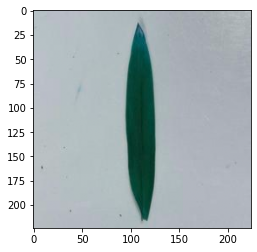

<Figure size 432x288 with 0 Axes>

Source: class: Verbina, file: Verbina/Verbina_125.JPEG
class: Verbina, confidence: 1.000000


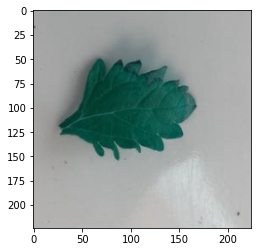

<Figure size 432x288 with 0 Axes>

Source: class: winka, file: winka/winka_105.jpeg
class: winka, confidence: 1.000000


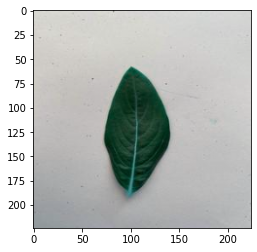

<Figure size 432x288 with 0 Axes>

Source: class: Chinese carnation, file: Chinese carnation/Chinese carnation_101.JPEG
class: Chinese carnation, confidence: 1.000000


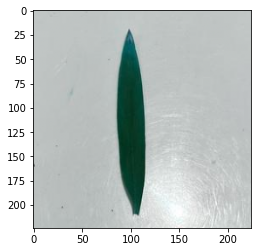

<Figure size 432x288 with 0 Axes>

Source: class: Colencha, file: Colencha/Colencha_133.JPEG
class: Colencha, confidence: 0.898700


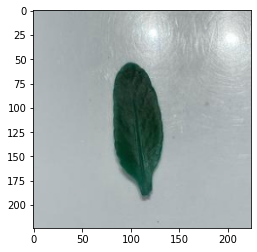

<Figure size 432x288 with 0 Axes>

Source: class: Pomegranate, file: Pomegranate/Pomegranate_112.JPG
class: Pomegranate, confidence: 0.998857


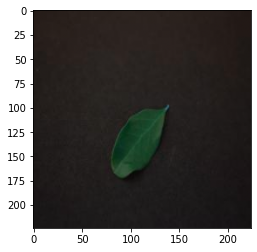

<Figure size 432x288 with 0 Axes>

Source: class: Geranium, file: Geranium/Geranium_12.jpeg
class: Geranium, confidence: 1.000000


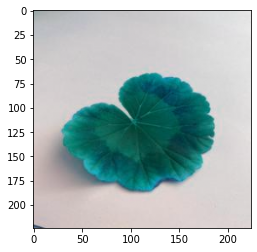

<Figure size 432x288 with 0 Axes>

In [ ]:
import random
import cv2
def upload(filename):
    img = cv2.imread(os.path.join(train_dir, filename))
    img = cv2.resize(img, (224, 224) )
    img = img /255
    
    return img

def pre_result(image):
    x = model.predict(np.asarray([img]))[0]
    classx = np.argmax(x)
    
    return {GATEGORIES[classx]: x[classx]}

images = random.sample(validation_generator.filenames, 20)

for idx, filename in enumerate(images):
    print('Source: class: %s, file: %s'% (os.path.split(filename)[0], filename))
    
    img = upload(filename)
    prediction = pre_result(img)
    print("class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
predictions1 = model.predict(validation_generator, steps=len(validation_generator))
y = np.argmax(predictions1, axis=1)

print('Classification Report')
cr = classification_report(y_true=validation_generator.classes, y_pred=y, target_names=validation_generator.class_indices)
print(cr)

evaluates = model.evaluate(validation_generator)

print(evaluates)

Classification Report
                   precision    recall  f1-score   support

          Araowla       0.98      1.00      0.99        55
Chinese carnation       1.00      0.98      0.99        55
         Colencha       1.00      0.98      0.99        55
            Gauva       0.98      0.98      0.98        55
         Geranium       1.00      1.00      1.00        55
            Jamun       0.98      0.95      0.96        55
           Ocimum       1.00      1.00      1.00        55
 Ocimum basilicum       0.98      0.98      0.98        55
          Petunia       0.98      1.00      0.99        55
      Pomegranate       0.96      0.98      0.97        55
 Pongamia Pinnata       0.98      1.00      0.99        55
          Tagetes       1.00      1.00      1.00        55
          Verbina       1.00      1.00      1.00        55
            winka       1.00      1.00      1.00        55

         accuracy                           0.99       770
        macro avg       0.99    

Confusion Matrix


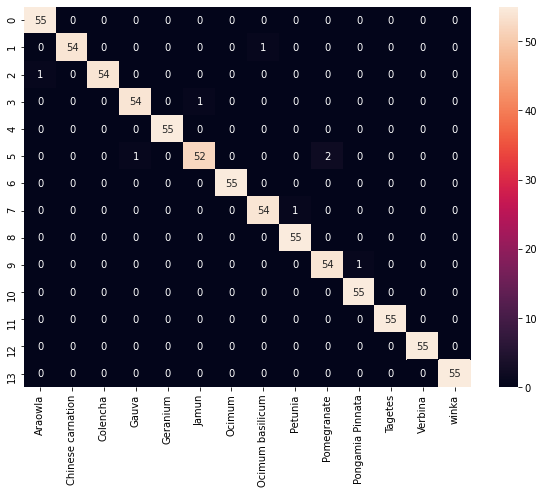

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
print('Confusion Matrix')
cm = confusion_matrix(validation_generator.classes, y)
df = pd.DataFrame(cm, columns=validation_generator.class_indices)
plt.figure(figsize=(10,7))
sn.heatmap(df, annot=True)

In [ ]:
export_path = "MobileNettwo"
tf.keras.models.save_model(model, export_path)
export_path


INFO:tensorflow:Assets written to: MobileNettwo/assets


INFO:tensorflow:Assets written to: MobileNettwo/assets


'MobileNettwo'

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image, ImageTk
from keras.models import load_model
#model2= keras.models.load_model(saved_model, compile= False)
lites='MobileNettwo.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
name = lites

with open(name, 'wb') as f:
  f.write(tflite_model)




INFO:tensorflow:Assets written to: /tmp/tmpbbcoefrt/assets


INFO:tensorflow:Assets written to: /tmp/tmpbbcoefrt/assets
